# String Matching Problem with Genetic Algorithm

This notebook demonstrates how to solve the string matching problem using the genetic algorithm implemented in `src/lib/ga.py`.

In this problem, we try to evolve a population of strings to match a target string.

In [1]:
# Add path to the central init_notebook.py file
import sys
from pathlib import Path
doc_dir = Path().absolute().parent  # This points to the doc/ directory
if str(doc_dir) not in sys.path:
    sys.path.insert(0, str(doc_dir))

# Now import everything with one line
from init_notebook import GeneticAlgorithm, AssetType, am, torch, np, plt

# Additional imports
import string
from dataclasses import dataclass

Added c:\Users\fire\Documents\Code\python\ai to Python path
Set random seeds to 42


## Define Data Structures and Helper Functions

First, we define the classes and functions that will be used in our string matching problem.

In [2]:
@dataclass
class StringMatchingData:
    """Class to store string matching problem data"""
    target_string: str
    charset: str  # Set of possible characters
    char_to_idx: dict  # Mapping from characters to indices
    idx_to_char: dict  # Mapping from indices to characters

In [3]:
def create_string_matching_data(
    target_string: str, charset: str = None
) -> StringMatchingData:
    """
    Creates a data object for the string matching problem
    
    Args:
        target_string: Target string to match
        charset: Set of possible characters (if None, a default set will be used)
        
    Returns:
        StringMatchingData object with problem data
    """
    if charset is None:
        # Default charset: letters, numbers, and common symbols
        charset = string.ascii_letters + string.digits + string.punctuation + " "
    
    # Create mappings between characters and indices
    char_to_idx = {char: idx for idx, char in enumerate(charset)}
    idx_to_char = {idx: char for idx, char in enumerate(charset)}
    
    return StringMatchingData(
        target_string=target_string,
        charset=charset,
        char_to_idx=char_to_idx,
        idx_to_char=idx_to_char,
    )

In [4]:
def string_matching_fitness(
    population: torch.Tensor, problem_data: StringMatchingData
) -> torch.Tensor:
    """
    Fitness function for the string matching problem
    
    Args:
        population: Population tensor [pop_size, chromosome_length]
                   Each "gene" is a value between 0 and 1 that will be mapped to a character index
        problem_data: Problem data
        
    Returns:
        Tensor with fitness values for each individual
    """
    pop_size, chromosome_length = population.shape
    charset_size = len(problem_data.charset)
    target_indices = torch.tensor(
        [problem_data.char_to_idx[char] for char in problem_data.target_string]
    )
    
    # Scale and round continuous inputs to discrete character indices
    # Multiply by charset_size-1 and round to get indices between 0 and charset_size-1
    indices = torch.round(population * (charset_size - 1)).long()
    
    # Calculate fitness based on how many characters match the target string
    fitness = torch.zeros(pop_size)
    
    for i in range(pop_size):
        # Character-based distance approach
        # The closer each character is to the target, the higher the fitness
        char_distances = 1.0 - torch.abs(indices[i] - target_indices) / charset_size
        fitness[i] = torch.sum(char_distances)
        
    return fitness

In [5]:
def decode_chromosome(
    chromosome: torch.Tensor, problem_data: StringMatchingData
) -> str:
    """
    Decodes a chromosome into a string
    
    Args:
        chromosome: Chromosome tensor [chromosome_length]
        problem_data: Problem data
        
    Returns:
        Decoded string
    """
    charset_size = len(problem_data.charset)
    indices = torch.round(chromosome * (charset_size - 1)).long().tolist()
    return "".join(problem_data.idx_to_char[idx] for idx in indices)

In [6]:
def display_solution(chromosome: torch.Tensor, problem_data: StringMatchingData):
    """
    Displays the solution found for the string matching problem
    
    Args:
        chromosome: Chromosome (solution) found
        problem_data: Problem data
    """
    solution_string = decode_chromosome(chromosome, problem_data)
    target_string = problem_data.target_string
    
    print("\nString Matching Result:")
    print(f"Target string: '{target_string}'")
    print(f"Best solution:  '{solution_string}'")
    
    # Show matches
    matches = sum(1 for a, b in zip(target_string, solution_string) if a == b)
    match_percentage = (matches / len(target_string)) * 100
    
    print(
        f"\nMatching characters: {matches}/{len(target_string)} ({match_percentage:.2f}%)"
    )
    
    # Visualize matches by character
    print("\nMatches by character:")
    for i, (target, solution) in enumerate(zip(target_string, solution_string)):
        match_indicator = "✓" if target == solution else "✗"
        print(
            f"Position {i}: Target='{target}' Solution='{solution}' {match_indicator}"
        )

## Solve the String Matching Problem

Now we'll set up and solve the string matching problem using our genetic algorithm.

In [7]:
# Problem configuration
target_string = "Hello, Genetic Algorithm!"
population_size = 100
n_generations = 300

print(f"\033[92mString Matching Problem\033[0m\n")
print(f"Target string: '{target_string}'")

# Create the problem data object
problem_data = create_string_matching_data(target_string)

String Matching Problem

Target string: 'Hello, Genetic Algorithm!'


In [8]:
# Create and run the genetic algorithm
ga = GeneticAlgorithm(
    pop_size=population_size,
    chromosome_length=len(target_string),
    fitness_function=string_matching_fitness,
    problem_data=problem_data,
    mutation_rate=0.1,
    crossover_rate=0.8,
    elitism=5,
    maximize=True,
    binary=False,  # Using continuous representation for this problem
)

In [9]:
# Track best solutions throughout the generations
best_solutions = []

# Define a callback function to show progress
def generation_callback(generation, best_chromosome, best_fitness):
    if generation % 10 == 0 or generation == n_generations - 1:
        solution = decode_chromosome(best_chromosome, problem_data)
        best_solutions.append(solution)
        print(
            f"Generation {generation + 1}: '{solution}' (Fitness: {best_fitness:.2f})"
        )

# Run the genetic algorithm with tracking
for gen in range(n_generations):
    best_chromosome, best_fitness = ga.evolve()
    generation_callback(gen, best_chromosome, best_fitness)

Generation 1: 'jpblJ<3lj)mP)zQRKxfjw}yp6' (Fitness: 19.23)
Generation 11: 'Dcplu=#ecLnvlq?Qomkjwmkj&' (Fitness: 22.73)
Generation 21: 'EcklJ= Gftgwlq`yjmmrkqlo#' (Fitness: 24.02)
Generation 31: 'Ecplo) Gftgwlc`yjemrkqlp#' (Fitness: 24.43)
Generation 41: 'Egnlo) Gfsewlc yjgmqkwll"' (Fitness: 24.58)
Generation 51: 'Fcllo- Gftgufa Ajgmrjqgo8' (Fitness: 24.65)
Generation 61: 'Egnlo, Gengulc Ajgmrjulo#' (Fitness: 24.72)
Generation 71: 'Efllo- Gengtlc Ajgmrivgo#' (Fitness: 24.78)
Generation 81: 'Fcllo, Gengtlc Akgmrivgm#' (Fitness: 24.82)
Generation 91: 'Gcllo, Gengtlc Akgmrivgm#' (Fitness: 24.83)
Generation 101: 'Fdllp, Gengtgc Akgmrivgm!' (Fitness: 24.85)
Generation 111: 'Fdllp, Gengtgc Akgmrivgm!' (Fitness: 24.85)
Generation 121: 'Fdllp, Genftgc Akgmrivgm!' (Fitness: 24.86)
Generation 131: 'Gcllo, Genftgc Akgmrivgm!' (Fitness: 24.87)
Generation 141: 'Gcllo, Genftgc Akgmrivgm!' (Fitness: 24.87)
Generation 151: 'Gello, Genftgc Akgmrivgm!' (Fitness: 24.89)
Generation 161: 'Gello, Genftgc Akg

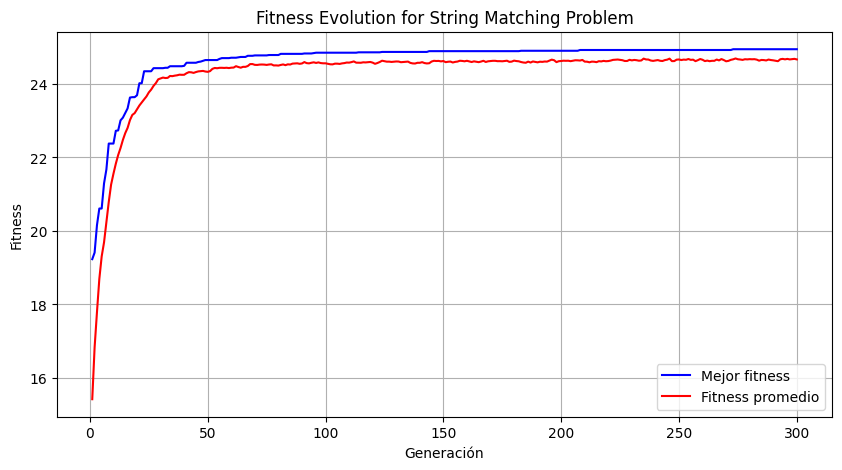

In [10]:
# Visualize results
ga.plot_history(
    title="Fitness Evolution for String Matching Problem"
)

In [11]:
# Display detailed solution information
display_solution(ga.best_chromosome, problem_data)


String Matching Result:
Target string: 'Hello, Genetic Algorithm!'
Best solution:  'Hello, Genftic Algpsiugm!'

Matching characters: 20/25 (80.00%)

Matches by character:
Position 0: Target='H' Solution='H' ✓
Position 1: Target='e' Solution='e' ✓
Position 2: Target='l' Solution='l' ✓
Position 3: Target='l' Solution='l' ✓
Position 4: Target='o' Solution='o' ✓
Position 5: Target=',' Solution=',' ✓
Position 6: Target=' ' Solution=' ' ✓
Position 7: Target='G' Solution='G' ✓
Position 8: Target='e' Solution='e' ✓
Position 9: Target='n' Solution='n' ✓
Position 10: Target='e' Solution='f' ✗
Position 11: Target='t' Solution='t' ✓
Position 12: Target='i' Solution='i' ✓
Position 13: Target='c' Solution='c' ✓
Position 14: Target=' ' Solution=' ' ✓
Position 15: Target='A' Solution='A' ✓
Position 16: Target='l' Solution='l' ✓
Position 17: Target='g' Solution='g' ✓
Position 18: Target='o' Solution='p' ✗
Position 19: Target='r' Solution='s' ✗
Position 20: Target='i' Solution='i' ✓
Position 21: Target

In [12]:
# Visualize the evolution of solutions
print("\nEvolution of best solutions:")
for i, solution in enumerate(best_solutions):
    if i % 5 == 0:  # Show every 5th generation to avoid cluttering the output
        gen_num = i * 10  # Since we saved every 10 generations
        print(f"Generation {gen_num + 1}: '{solution}'")


Evolution of best solutions:
Generation 1: 'jpblJ<3lj)mP)zQRKxfjw}yp6'
Generation 51: 'Fcllo- Gftgufa Ajgmrjqgo8'
Generation 101: 'Fdllp, Gengtgc Akgmrivgm!'
Generation 151: 'Gello, Genftgc Akgmrivgm!'
Generation 201: 'Hello, Genftgc Akgmrivgm!'
Generation 251: 'Hello, Genftgc Algpsiugm!'
Generation 301: 'Hello, Genftic Algpsiugm!'


## Save Results to Temp Directory

We'll save the fitness evolution chart for future reference.

In [13]:
# Ensure temp directory exists
temp_dir = am.get_asset_path(AssetType.TEMP)
am.ensure_path_exists(temp_dir)

# Create and save the figure
plt.figure(figsize=(10, 5))
generations = range(1, len(ga.best_fitness_history) + 1)
plt.plot(generations, ga.best_fitness_history, 'b-', label='Best Fitness')
plt.plot(generations, ga.avg_fitness_history, 'r-', label='Average Fitness')
plt.title("String Matching Fitness Evolution")
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.legend()
plt.grid(True)

# Get path for saving and save
save_path = am.get_temp('string_matching_results.png', absolute=True)
plt.savefig(save_path)
plt.close()

print(f"Saved results to: {save_path}")

Saved results to: c:\Users\fire\Documents\Code\python\ai\data\temp\string_matching_results.png


In [14]:
# Try a more challenging example
long_string = "This is a longer string that should be more challenging for the genetic algorithm to match perfectly."
problem_data_long = create_string_matching_data(long_string)

# Create and run the genetic algorithm for the longer string
ga_long = GeneticAlgorithm(
    pop_size=200,  # Larger population for more complex problem
    chromosome_length=len(long_string),
    fitness_function=string_matching_fitness,
    problem_data=problem_data_long,
    mutation_rate=0.05,
    crossover_rate=0.9,
    elitism=10,
    maximize=True,
    binary=False,
)

print(f"\nLonger string challenge:")
print(f"Target: '{long_string}'")
print("\nRunning genetic algorithm...")

# Track progress at larger intervals
for gen in range(0, 500, 50):
    for _ in range(50):  # Run 50 generations at a time
        best_chromosome, best_fitness = ga_long.evolve()
    
    current_solution = decode_chromosome(best_chromosome, problem_data_long)
    print(f"Generation {gen + 50}: '{current_solution}'")

# Display final result
display_solution(ga_long.best_chromosome, problem_data_long)


Longer string challenge:
Target: 'This is a longer string that should be more challenging for the genetic algorithm to match perfectly.'

Running genetic algorithm...
Generation 50: 'Qjno^ls E tevJns ufAlAq-ykZA~ddpwwl ex qoog_Vygotnmaup5^foJ|xrj\kJovqxaVjhdiTrtuj*nB mhEIa>nqlgieovC"'
Generation 100: 'Tknq lm h oorsbt Cssmpn tgas oisylh ca_qpna eugjlmmahpr fbr uag kaodvql ajkkwkpfq rj~mauak mhhggaqlz-'
Generation 150: 'Tfhq ls h konhbt rupjnn tias oimvka aa qpqa ehajlamgipd dqs uie~kenevjf ajhrtkugi qq~matbk ncqfectmv-'
Generation 200: 'Tfhq ls a konhbt rupjng tiau oimvka aa qpna ehajlamgipd fqo uie~kenevjb ajhrtkugi vq~matbk ncqfectnv-'
Generation 250: 'Tfhq js a kolhat qupjng tias siovka aa qpra ehablamgipd fps uie~genevma aihotkugl vq~matah neqfectlv-'
Generation 300: 'Tfhq ls a kongbt rupjng tias siovka aa qpra egablemgiph fps uie~genevjh amhotkugl vq latah ncqfectlv-'
Generation 350: 'Tfhq ls a kongbt rupjng tias siovka aa lprc egallemgiph dos uie~genevjh amiotgygl vq latah ncqfe